In [1]:
import os
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import yaml
from yaml import Loader
import numpy as np
import analyze_cells_energy as ace
import utils
from scipy.stats import ttest_ind, mannwhitneyu
import networkx as nx
import matplotlib.pyplot as plt
import copy
import itertools

In [2]:
# todo: mettere abbreviazione

In [3]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'C57_MaleUrine_Exposure_cFos'
subjects = ace.list_subjects(root_directory)
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'
# load query file where we added volumes for each area
volumes = pd.read_csv("query_volumes_reordered.csv")
volumes = ace.clean_volumes_database(volumes)

In [4]:
volumes

id  atlas_id                           name acronym  st_level  \
0           997      -1.0                           root    root         0   
1             8       0.0  Basic cell groups and regions    grey         1   
2           567      70.0                       Cerebrum      CH         2   
3           688      85.0                Cerebral cortex     CTX         3   
4           695      86.0                 Cortical plate   CTXpl         4   
...         ...       ...                            ...     ...       ...   
1322         49     713.0     intraparafloccular fissure     ipf         8   
1323         57     714.0              paramedian sulcus     pms         8   
1324         65     715.0           parafloccular sulcus     pfs         8   
1325        624     926.0          Interpeduncular fossa     IPF         7   
1326  304325711       NaN                         retina  retina         1   

      parent_structure_id  depth    structure_id_path  \
0                     NaN      0                /997/   
1                   997.0      1              /997/8/   
2                     8.0      2          /997/8/567/   
3                   567.0      3      /997/8/567/688/   
4                   688.0      4  /997/8/567/688/695/   
...                   ...    ...                  ...   
1322               1040.0      3   /997/1024/1040/49/   
1323               1040.0      3   /997/1024/1040/57/   
1324               1040.0      3   /997/1024/1040/65/   
1325               1024.0      2       /997/1024/624/   
1326                997.0      1      /997/304325711/   

                          safe_name  mean_volume  ...            1       2  \
0                              root   435.287861  ...          NaN     NaN   
1     Basic cell groups and regions   197.462441  ...          8.0     NaN   
2                          Cerebrum   120.883542  ...          8.0   567.0   
3                   Cerebral cortex    97.403809  ...          8.0   567.0   
4                    Cortical plate    93.461964  ...          8.0   567.0   
...                             ...          ...  ...          ...     ...   
1322     intraparafloccular fissure          NaN  ...       1024.0  1040.0   
1323              paramedian sulcus          NaN  ...       1024.0  1040.0   
1324           parafloccular sulcus          NaN  ...       1024.0  1040.0   
1325          Interpeduncular fossa          NaN  ...       1024.0   624.0   
1326                         retina          NaN  ...  304325711.0     NaN   

          3      4   5   6   7   8   9  10  
0       NaN    NaN NaN NaN NaN NaN NaN NaN  
1       NaN    NaN NaN NaN NaN NaN NaN NaN  
2       NaN    NaN NaN NaN NaN NaN NaN NaN  
3     688.0    NaN NaN NaN NaN NaN NaN NaN  
4     688.0  695.0 NaN NaN NaN NaN NaN NaN  
...     ...    ...  ..  ..  ..  ..  ..  ..  
1322   49.0    NaN NaN NaN NaN NaN NaN NaN  
1323   57.0    NaN NaN NaN NaN NaN NaN NaN  
1324   65.0    NaN NaN NaN NaN NaN NaN NaN  
1325    NaN    NaN NaN NaN NaN NaN NaN NaN  
1326    NaN    NaN NaN NaN NaN NaN NaN NaN  

[1327 rows x 21 columns]

In [5]:
def select_significant_areas(df, threshold=0.05):
    tests = ['pval_Control_vs_Fam', 'pval_Control_vs_Unfam', 'pval_Fam_vs_Unfam']
    d = []
    for key in tests:
        d.append(df.sort_values(by=key)[[
        'area', key]]['area'][df.sort_values(by=key)[[
        'area', key]][key] < threshold].to_list())
    # return flattened list
    return list(itertools.chain.from_iterable(d))

In [36]:
def plot_graph(corr_matrix, title, ax, significant_areas=None, corr_threshold=0.85):
    df_graph = corr_matrix.stack().reset_index(level=0)
    df_graph.columns = ['area2', 'corr']
    df_graph = df_graph.reset_index()
    df_graph.columns = ['area1', 'area2', 'corr']
    # subsample areas only if the significant areas are given
    if significant_areas is not None:
        df_graph = df_graph.loc[df_graph['area1'].isin(significant_areas)]
        df_graph = df_graph.loc[df_graph['area2'].isin(significant_areas)]
        
    # Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
    links_filtered=df_graph.loc[(df_graph['corr'] > corr_threshold) & 
                                (df_graph['area1'] != df_graph['area2']) & 
                                (df_graph['corr'] != 1)]

    # Build your graph
    G=nx.from_pandas_edgelist(links_filtered, 'area1', 'area2')

    # Plot the network:
    pos = nx.circular_layout(G)
    nx.draw(G, with_labels=True, node_color='orange', node_size=20, edge_color='black', linewidths=1, 
            font_size=12, pos=pos, ax=ax)
    ax.set_title(title)
    return ax

# C57 mice

In [7]:
dict_results_across_mice = np.load('dict_results_across_mice_c57.npy', allow_pickle=True).item()

In [8]:
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)

In [9]:
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')

In [10]:
df_ttest_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count)
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
df_mannwhitneyu_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count,
                                           test='mannwhitneyu')
df_mannwhitneyu_not_null_ncells = df_mannwhitneyu_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [11]:
sig_areas_ncells_ttest = select_significant_areas(df=df_ttest_not_null_ncells, threshold=0.05)
sig_areas_ncells_mannwhitneyu = select_significant_areas(df=df_mannwhitneyu_not_null_ncells, threshold=0.05)

In [12]:
corr_matrix_control_ncells = ace.cross_corr(df_control_cell_count)
corr_matrix_fam_ncells = ace.cross_corr(df_fam_cell_count)
corr_matrix_unfam_ncells = ace.cross_corr(df_unfam_cell_count)

# Graph control

## only on correlations - ncells

<AxesSubplot:title={'center':'ncells UNFAM'}>

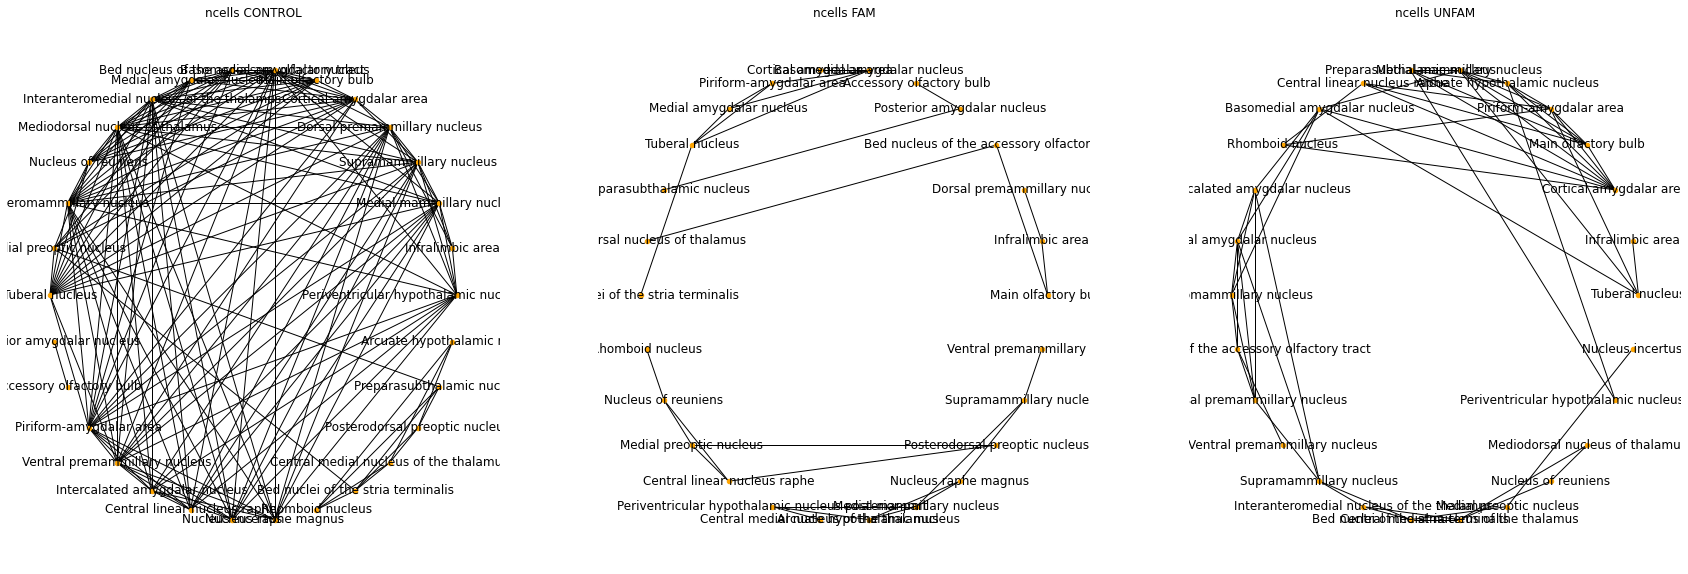

In [13]:
fig, axes = plt.subplots(1,3, figsize=(30,10))
plot_graph(corr_matrix=corr_matrix_control_ncells, significant_areas=sig_areas_ncells_ttest, 
           ax=axes[0], title='ncells CONTROL')
plot_graph(corr_matrix=corr_matrix_fam_ncells,  significant_areas=sig_areas_ncells_ttest, 
           ax=axes[1], title='ncells FAM')
plot_graph(corr_matrix=corr_matrix_unfam_ncells,  significant_areas=sig_areas_ncells_ttest, 
           ax=axes[2], title='ncells UNFAM')

## only on correlation - energy

In [14]:
df_control_energy, df_fam_energy, df_unfam_energy = \
ace.calculate_value_across_groups(experimental_groups, dict_results_across_mice, value='energy')

In [15]:
df_ttest_energy = ace.test_across_groups(df_control=df_control_energy,
                                      df_fam=df_fam_energy,
                                      df_unfam=df_unfam_energy)
df_ttest_not_null_energy = df_ttest_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
df_mannwhitneyu_energy = ace.test_across_groups(df_control=df_control_energy,
                                      df_fam=df_fam_energy,
                                      df_unfam=df_unfam_energy,
                                    test='mannwhitneyu')
df_mannwhitneyu_not_null_energy = df_mannwhitneyu_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])

In [16]:
sig_areas_energy_ttest = select_significant_areas(df=df_ttest_not_null_energy, threshold=0.05)
sig_areas_energy_mannwhitneyu = select_significant_areas(df=df_mannwhitneyu_not_null_energy, threshold=0.05)

In [17]:
corr_matrix_control_energy = ace.cross_corr(df_control_energy)
corr_matrix_fam_energy = ace.cross_corr(df_fam_energy)
corr_matrix_unfam_energy = ace.cross_corr(df_unfam_energy)

<AxesSubplot:title={'center':'energy UNFAM'}>

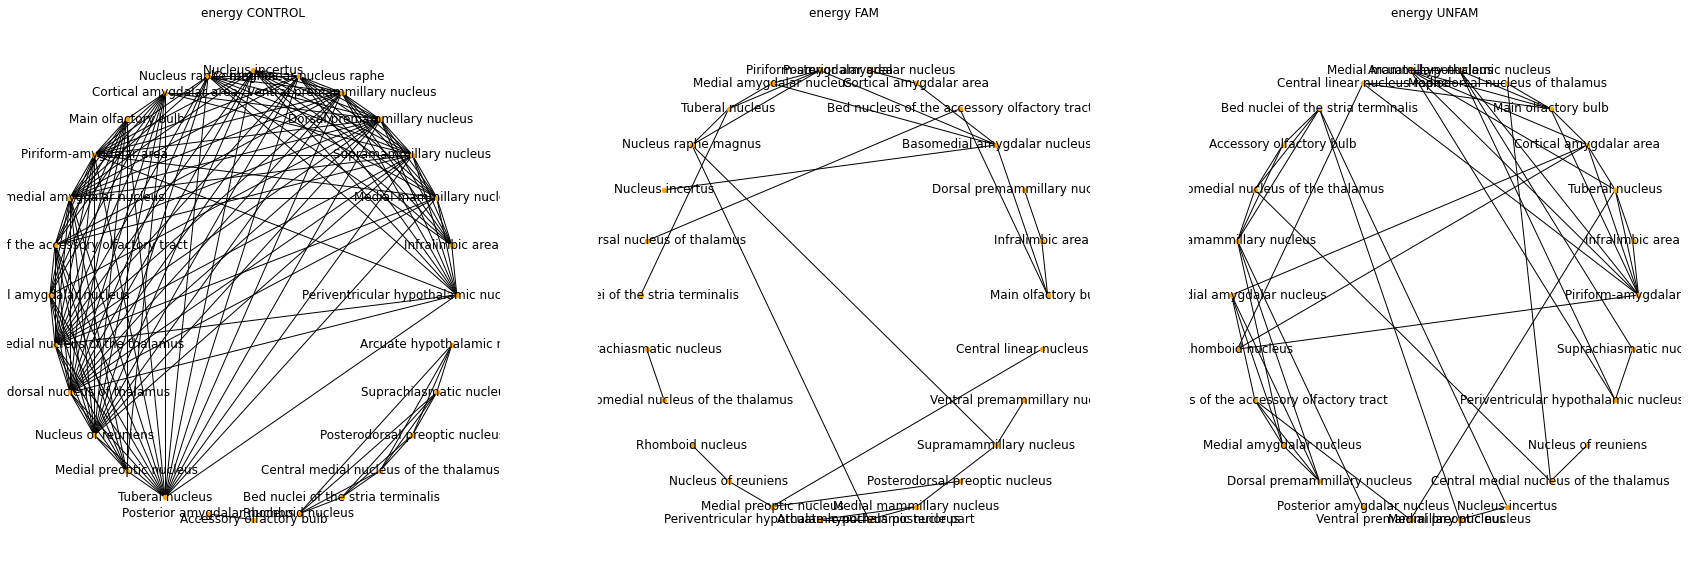

In [18]:
fig, axes = plt.subplots(1,3, figsize=(30,10))
plot_graph(corr_matrix=corr_matrix_control_energy, significant_areas=sig_areas_energy_ttest, 
           ax=axes[0], title='energy CONTROL')
plot_graph(corr_matrix=corr_matrix_fam_energy,  significant_areas=sig_areas_energy_ttest, 
           ax=axes[1], title='energy FAM')
plot_graph(corr_matrix=corr_matrix_unfam_energy,  significant_areas=sig_areas_energy_ttest, 
           ax=axes[2], title='energy UNFAM')

# SWISS 1-18

In [19]:
root_directory = '/home/stella/Documents/Torino/projects/'
experiment = 'SexualImprinting'
experimental_group = 'SWISS_MaleUrine_Exposure'
subjects = ace.list_subjects(root_directory)
data_directory = root_directory + experiment + '/' \
                + experimental_group + '/'

In [20]:
subjects = [name for name in os.listdir(data_directory) \
                if os.path.isdir(os.path.join(data_directory, name))]

In [21]:
subjects = [sub for sub in subjects if sub[0:2]=='SW' and int(sub[2:].split('_')[0]) in set(range(2,19))]

In [22]:
dict_results_across_mice = np.load('dict_results_across_mice_SW1-18.npy', allow_pickle=True).item()
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')
df_ttest_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count)
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
df_mannwhitneyu_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count,
                                           test='mannwhitneyu')
df_mannwhitneyu_not_null_ncells = df_mannwhitneyu_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
sig_areas_ncells_ttest = select_significant_areas(df=df_ttest_not_null_ncells, threshold=0.05)
sig_areas_ncells_mannwhitneyu = select_significant_areas(df=df_mannwhitneyu_not_null_ncells, threshold=0.05)
corr_matrix_control_ncells = ace.cross_corr(df_control_cell_count)
corr_matrix_fam_ncells = ace.cross_corr(df_fam_cell_count)
corr_matrix_unfam_ncells = ace.cross_corr(df_unfam_cell_count)

<AxesSubplot:title={'center':'ncells UNFAM'}>

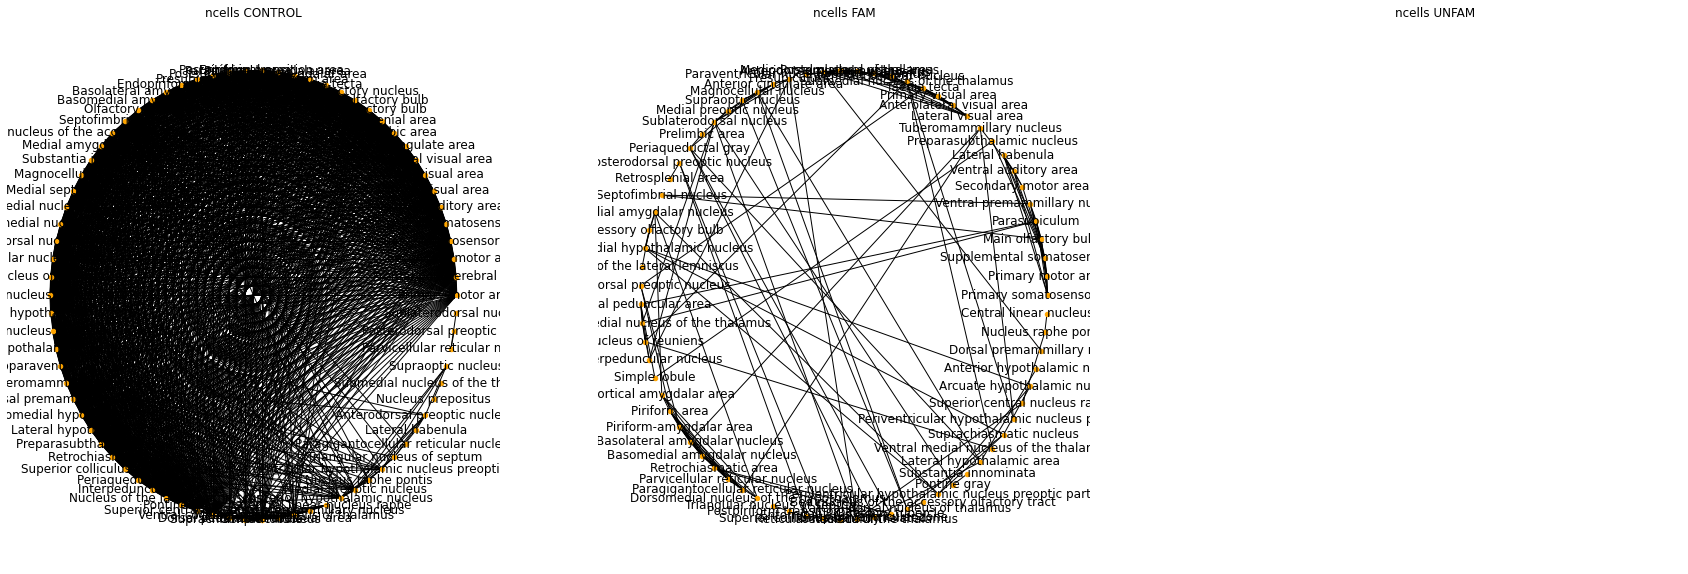

In [23]:
fig, axes = plt.subplots(1,3, figsize=(30,10))
plot_graph(corr_matrix=corr_matrix_control_ncells, significant_areas=sig_areas_ncells_ttest, 
           ax=axes[0], title='ncells CONTROL')
plot_graph(corr_matrix=corr_matrix_fam_ncells,  significant_areas=sig_areas_ncells_ttest, 
           ax=axes[1], title='ncells FAM')
plot_graph(corr_matrix=corr_matrix_unfam_ncells,  significant_areas=sig_areas_ncells_ttest, 
           ax=axes[2], title='ncells UNFAM')

In [24]:
df_control_energy, df_fam_energy, df_unfam_energy = \
ace.calculate_value_across_groups(experimental_groups, dict_results_across_mice, value='energy')
df_ttest_energy = ace.test_across_groups(df_control=df_control_energy,
                                      df_fam=df_fam_energy,
                                      df_unfam=df_unfam_energy)
df_ttest_not_null_energy = df_ttest_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
df_mannwhitneyu_energy = ace.test_across_groups(df_control=df_control_energy,
                                      df_fam=df_fam_energy,
                                      df_unfam=df_unfam_energy,
                                    test='mannwhitneyu')
df_mannwhitneyu_not_null_energy = df_mannwhitneyu_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
sig_areas_energy_ttest = select_significant_areas(df=df_ttest_not_null_energy, threshold=0.05)
sig_areas_energy_mannwhitneyu = select_significant_areas(df=df_mannwhitneyu_not_null_energy, threshold=0.05)
corr_matrix_control_energy = ace.cross_corr(df_control_energy)
corr_matrix_fam_energy = ace.cross_corr(df_fam_energy)
corr_matrix_unfam_energy = ace.cross_corr(df_unfam_energy)

<AxesSubplot:title={'center':'energy UNFAM'}>

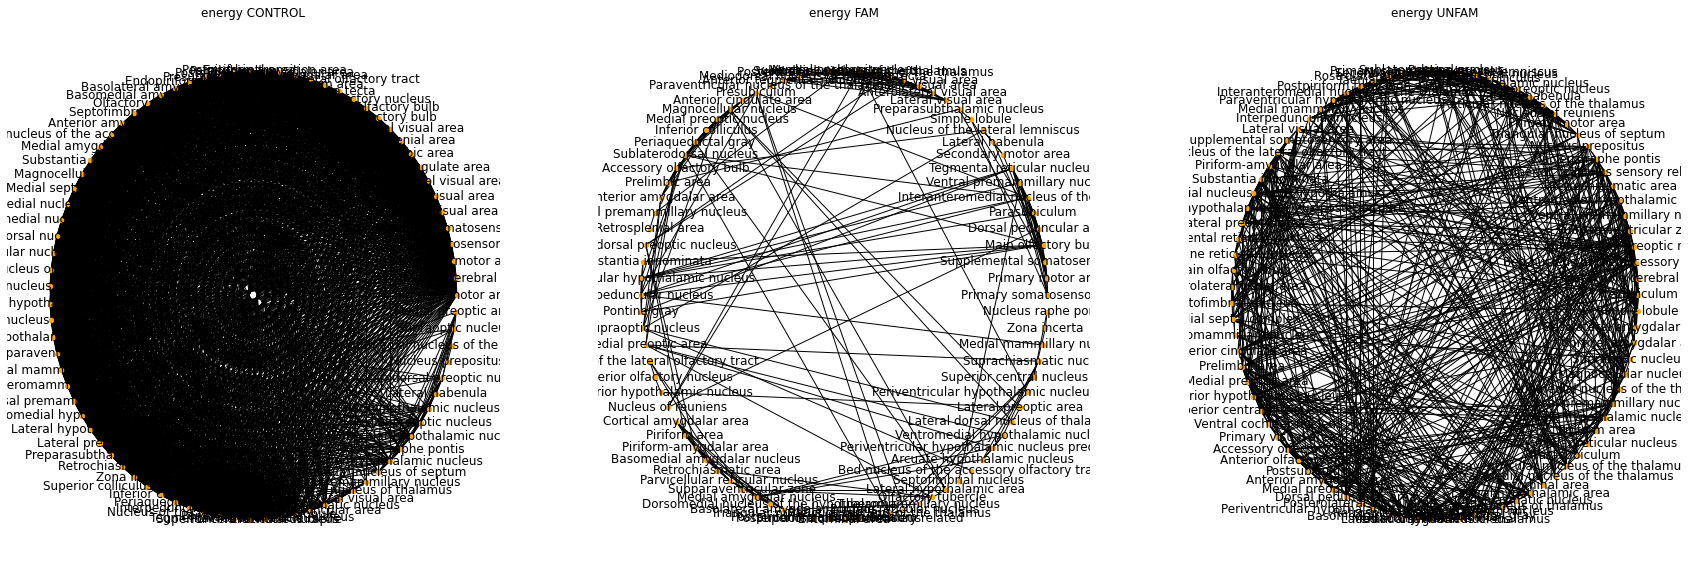

In [25]:
fig, axes = plt.subplots(1,3, figsize=(30,10))
plot_graph(corr_matrix=corr_matrix_control_energy, significant_areas=sig_areas_energy_ttest, 
           ax=axes[0], title='energy CONTROL')
plot_graph(corr_matrix=corr_matrix_fam_energy,  significant_areas=sig_areas_energy_ttest, 
           ax=axes[1], title='energy FAM')
plot_graph(corr_matrix=corr_matrix_unfam_energy,  significant_areas=sig_areas_energy_ttest, 
           ax=axes[2], title='energy UNFAM')

# SWISS 19-35

In [26]:
subjects = [name for name in os.listdir(data_directory) \
                if os.path.isdir(os.path.join(data_directory, name))]
subjects = [sub for sub in subjects if sub[0:2]=='SW' and int(sub[2:].split('_')[0]) in set(range(19,36))]
dict_results_across_mice = np.load('dict_results_across_mice_SW19-35.npy', allow_pickle=True).item()
experimental_groups = utils.divide_in_exp_groups(list_subjects=subjects)
df_control_cell_count, df_fam_cell_count, df_unfam_cell_count = \
ace.calculate_value_across_groups(experimental_groups=experimental_groups, 
                              dict_results_across_mice=dict_results_across_mice, 
                              value='n_cells')
df_ttest_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count)
df_ttest_not_null_ncells = df_ttest_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
df_mannwhitneyu_ncells = ace.test_across_groups(df_control=df_control_cell_count, 
                               df_fam=df_fam_cell_count, 
                               df_unfam=df_unfam_cell_count,
                                           test='mannwhitneyu')
df_mannwhitneyu_not_null_ncells = df_mannwhitneyu_ncells.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
sig_areas_ncells_ttest = select_significant_areas(df=df_ttest_not_null_ncells, threshold=0.05)
sig_areas_ncells_mannwhitneyu = select_significant_areas(df=df_mannwhitneyu_not_null_ncells, threshold=0.05)
corr_matrix_control_ncells = ace.cross_corr(df_control_cell_count)
corr_matrix_fam_ncells = ace.cross_corr(df_fam_cell_count)
corr_matrix_unfam_ncells = ace.cross_corr(df_unfam_cell_count)

<AxesSubplot:title={'center':'ncells UNFAM'}>

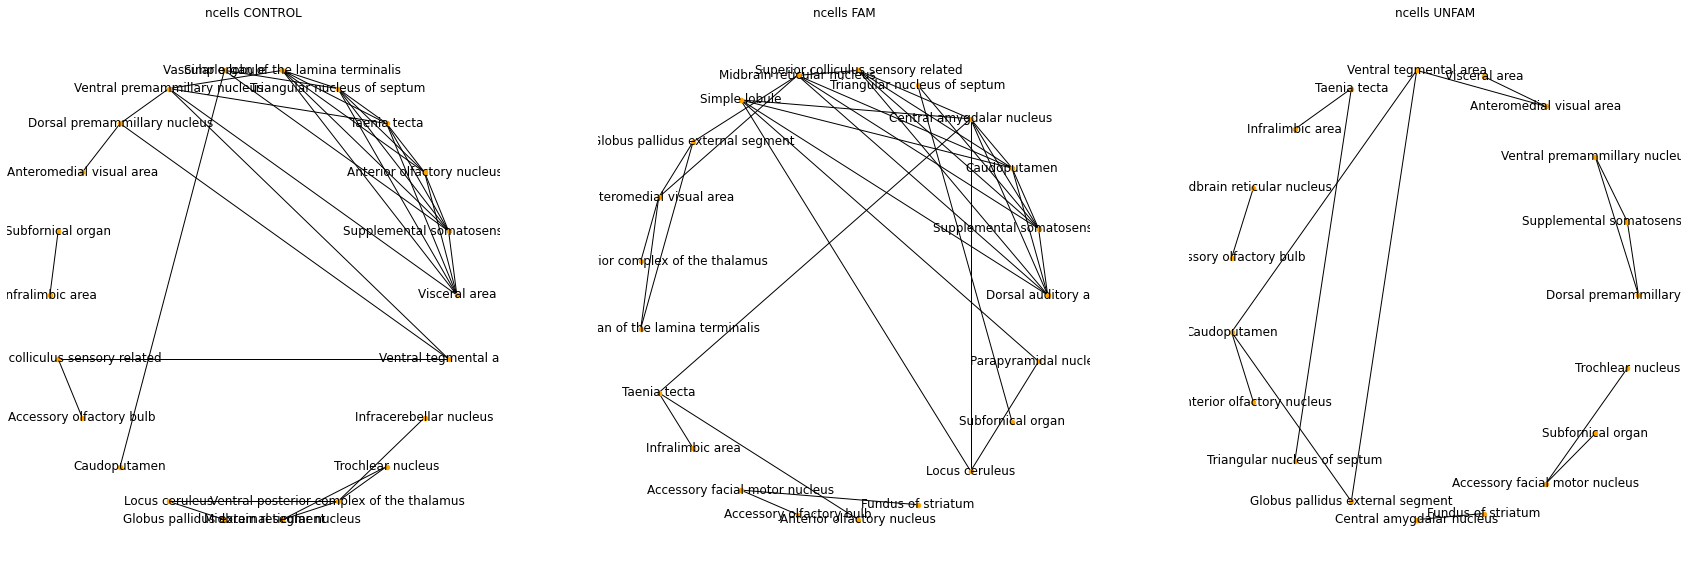

In [27]:
fig, axes = plt.subplots(1,3, figsize=(30,10))
plot_graph(corr_matrix=corr_matrix_control_ncells, significant_areas=sig_areas_ncells_ttest, 
           ax=axes[0], title='ncells CONTROL')
plot_graph(corr_matrix=corr_matrix_fam_ncells,  significant_areas=sig_areas_ncells_ttest, 
           ax=axes[1], title='ncells FAM')
plot_graph(corr_matrix=corr_matrix_unfam_ncells,  significant_areas=sig_areas_ncells_ttest, 
           ax=axes[2], title='ncells UNFAM')

In [28]:
df_control_energy, df_fam_energy, df_unfam_energy = \
ace.calculate_value_across_groups(experimental_groups, dict_results_across_mice, value='energy')
df_ttest_energy = ace.test_across_groups(df_control=df_control_energy,
                                      df_fam=df_fam_energy,
                                      df_unfam=df_unfam_energy)
df_ttest_not_null_energy = df_ttest_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
df_mannwhitneyu_energy = ace.test_across_groups(df_control=df_control_energy,
                                      df_fam=df_fam_energy,
                                      df_unfam=df_unfam_energy,
                                    test='mannwhitneyu')
df_mannwhitneyu_not_null_energy = df_mannwhitneyu_energy.dropna(axis=0,
                                   how='all',
                                   subset=['pval_Control_vs_Fam',
                                          'pval_Control_vs_Unfam',
                                          'pval_Fam_vs_Unfam'])
sig_areas_energy_ttest = select_significant_areas(df=df_ttest_not_null_energy, threshold=0.05)
sig_areas_energy_mannwhitneyu = select_significant_areas(df=df_mannwhitneyu_not_null_energy, threshold=0.05)
corr_matrix_control_energy = ace.cross_corr(df_control_energy)
corr_matrix_fam_energy = ace.cross_corr(df_fam_energy)
corr_matrix_unfam_energy = ace.cross_corr(df_unfam_energy)

<AxesSubplot:title={'center':'energy UNFAM'}>

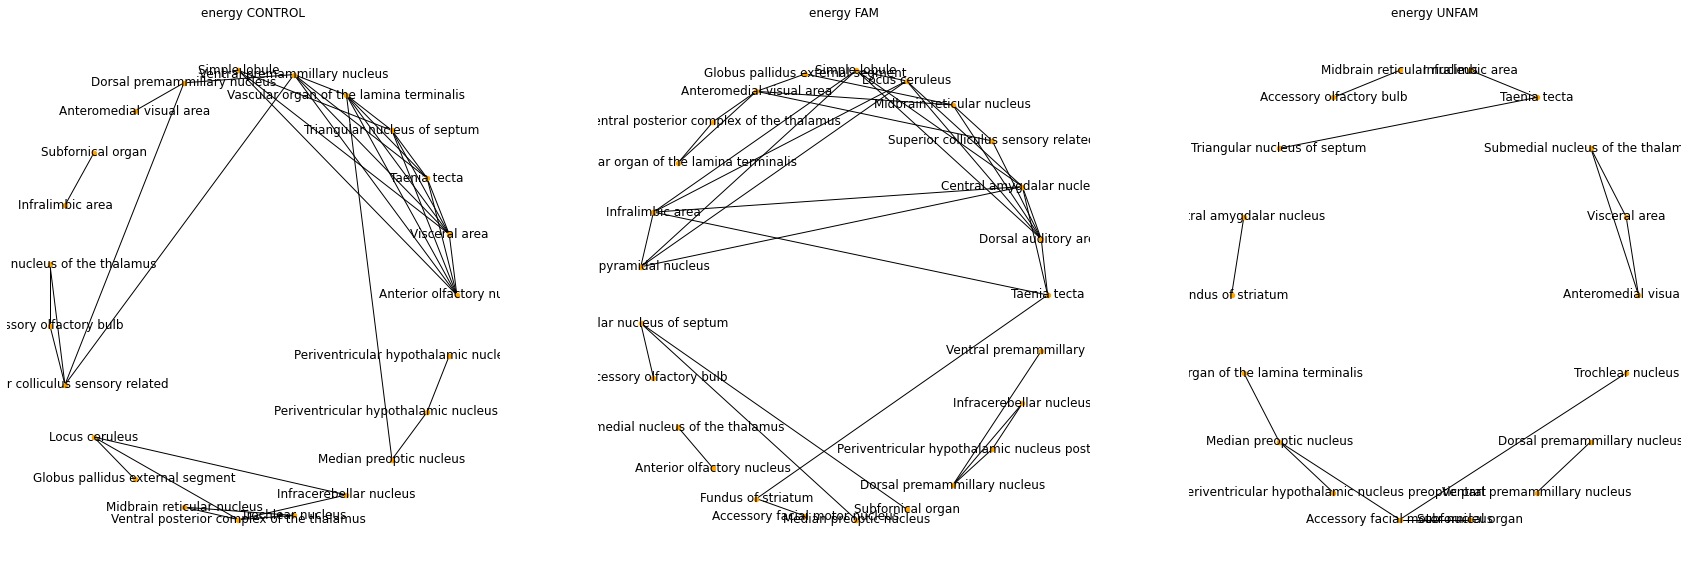

In [37]:
fig, axes = plt.subplots(1,3, figsize=(30,10))
plot_graph(corr_matrix=corr_matrix_control_energy, significant_areas=sig_areas_energy_ttest, 
           ax=axes[0], title='energy CONTROL')
plot_graph(corr_matrix=corr_matrix_fam_energy,  significant_areas=sig_areas_energy_ttest, 
           ax=axes[1], title='energy FAM')
plot_graph(corr_matrix=corr_matrix_unfam_energy,  significant_areas=sig_areas_energy_ttest, 
           ax=axes[2], title='energy UNFAM')

['Visceral area' 'Visceral area' 'Visceral area' 'Visceral area'
 'Visceral area' 'Visceral area' 'Visceral area' 'Visceral area'
 'Visceral area' 'Visceral area' 'Visceral area' 'Visceral area'
 'Visceral area' 'Visceral area' 'Visceral area' 'Visceral area'
 'Visceral area' 'Visceral area' 'Visceral area' 'Visceral area'
 'Visceral area' 'Visceral area' 'Visceral area' 'Visceral area'
 'Visceral area' 'Visceral area' 'Visceral area' 'Visceral area']
['Dorsal auditory area' 'Dorsal auditory area' 'Dorsal auditory area'
 'Dorsal auditory area' 'Dorsal auditory area' 'Dorsal auditory area'
 'Dorsal auditory area' 'Dorsal auditory area' 'Dorsal auditory area'
 'Dorsal auditory area' 'Dorsal auditory area' 'Dorsal auditory area'
 'Dorsal auditory area' 'Dorsal auditory area' 'Dorsal auditory area'
 'Dorsal auditory area' 'Dorsal auditory area' 'Dorsal auditory area'
 'Dorsal auditory area' 'Dorsal auditory area' 'Dorsal auditory area'
 'Dorsal auditory area' 'Dorsal auditory area' 'Dorsal

['Trochlear nucleus' 'Trochlear nucleus' 'Trochlear nucleus'
 'Trochlear nucleus' 'Trochlear nucleus' 'Trochlear nucleus'
 'Trochlear nucleus' 'Trochlear nucleus' 'Trochlear nucleus'
 'Trochlear nucleus' 'Trochlear nucleus' 'Trochlear nucleus'
 'Trochlear nucleus' 'Trochlear nucleus' 'Trochlear nucleus'
 'Trochlear nucleus' 'Trochlear nucleus' 'Trochlear nucleus'
 'Trochlear nucleus' 'Trochlear nucleus' 'Trochlear nucleus'
 'Trochlear nucleus' 'Trochlear nucleus' 'Trochlear nucleus'
 'Trochlear nucleus' 'Trochlear nucleus' 'Trochlear nucleus'
 'Trochlear nucleus']
['Locus ceruleus' 'Locus ceruleus' 'Locus ceruleus' 'Locus ceruleus'
 'Locus ceruleus' 'Locus ceruleus' 'Locus ceruleus' 'Locus ceruleus'
 'Locus ceruleus' 'Locus ceruleus' 'Locus ceruleus' 'Locus ceruleus'
 'Locus ceruleus' 'Locus ceruleus' 'Locus ceruleus' 'Locus ceruleus'
 'Locus ceruleus' 'Locus ceruleus' 'Locus ceruleus' 'Locus ceruleus'
 'Locus ceruleus' 'Locus ceruleus' 'Locus ceruleus' 'Locus ceruleus'
 'Locus ceruleu

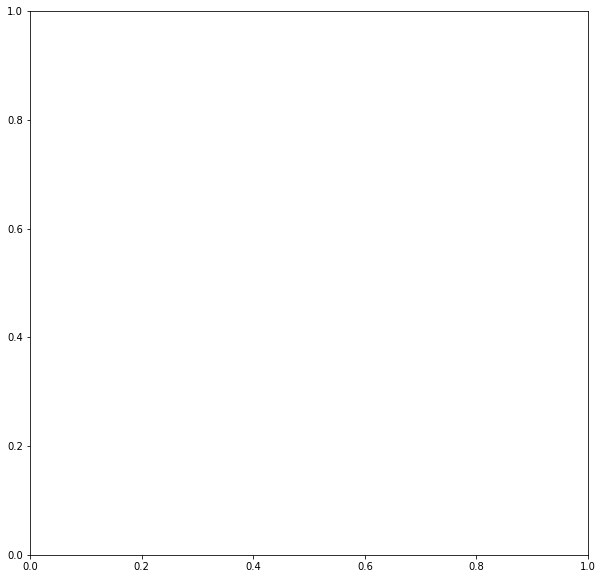

In [61]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
title='sciao'
corr_matrix = corr_matrix_control_energy.copy(deep=True)
significant_areas = sig_areas_energy_ttest
corr_threshold = 0.97
df_graph = corr_matrix.stack().reset_index(level=0)
df_graph.columns = ['area2', 'corr']
df_graph = df_graph.reset_index()
df_graph.columns = ['area1', 'area2', 'corr']
# subsample areas only if the significant areas are given
if significant_areas is not None:
    df_graph = df_graph.loc[df_graph['area1'].isin(significant_areas)]
    df_graph = df_graph.loc[df_graph['area2'].isin(significant_areas)]

    
# here rename df_graph with volumes acronym
for area in df_graph['area1']:
    print(df_graph.loc[df_graph['area1'] == area, 'area1'].values)
#     df_graph.loc[df_graph['area1'] == area, 'area1'] = volumes.loc[volumes['safe_name'] == area, 'acronym']
# volumes.loc[volumes['safe_name'] == area]['acronym']

In [ ]:
# Keep only correlation over a threshold and remove self correlation (cor(A,A)=1)
links_filtered=df_graph.loc[(df_graph['corr'] > corr_threshold) & 
                            (df_graph['area1'] != df_graph['area2']) & 
                            (df_graph['corr'] != 1)]

# Build your graph
G=nx.from_pandas_edgelist(links_filtered, 'area1', 'area2')

# Plot the network:
pos = nx.circular_layout(G)
nx.draw(G, with_labels=True, node_color='orange', node_size=20, edge_color='black', linewidths=1, 
        font_size=12, pos=pos, ax=ax)
ax.set_title(title)